In [1]:
#lo añadiré cuando sepa que todo funciona correctamente
#import LibreriaTFG as lib

In [2]:
import numpy as np  
import numpy.polynomial.legendre as npl
import sympy as sp
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy.interpolate import lagrange
import math 

In [3]:
def Transformation(nodes, weight,a,b):
    nodes=(b-a)/2*nodes+(a+b)/2
    weight=(b-a)/2 *weight
    return (nodes,weight)

def chop(lista):
    for i in range(len(lista)):
        if(abs(lista[i])<(10**(-10))):
            lista[i]=0
    return lista

class Cuadrature:
    def __init__(self,nodes=None,weight=None):
        if(list(nodes)!=None):
                self.nodes=nodes
        if(list(weight)!=None):
                self.weight=weight
        
    def getNodes(self):
        return self.nodes
    def getWeight(self):
        return self.weight
    def getNumPoints(self):
        return len(self.nodes)
    
    def Integrate(self,f):
        return self.Integrate_List(f(np.array(self.nodes)))
    
    def Integrate_List(self,lista):
        if (len(lista)==len(self.weight)):
            return np.array(lista).dot(np.array(self.weight))
        else:
            raise Exception("No has metido correctamente la lista")

class Lobato(Cuadrature):
    def __init__(self, num_points,a,b):
        aux=[-1,*sorted(list(legendre(num_points).deriv().r)),1]
        Cuadrature.__init__(self, nodes=np.array(aux), weight=np.array(2/(num_points*(num_points+1)*(legendre(num_points)(aux))**2)))
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

class Legendre(Cuadrature):
    def __init__(self,num_points,a,b):
        Cuadrature.__init__(self,nodes=npl.leggauss(num_points)[0], weight=npl.leggauss(num_points)[1]) 
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

class Trapecio_Compuesto(Cuadrature): #están considerados los extremos(-1,1)
    def __init__(self,num_points,a,b):
        Cuadrature.__init__(self, nodes=np.array([*np.arange(-1,1,float(2/num_points)).tolist(),1]), weight=np.array([2/(2*num_points),*[2/num_points]*(num_points-1),2/(2*num_points)]))
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

def Funciones_Base(N):
    '''
    Crea las funciones bases de grado N y devuelve un vector con las funciones bases y otro con sus derivadas
    '''
    x = sp.symbols('x')
    xvals = chop(Lobato(N,-1,1).getNodes())
    
    aux=np.zeros(N+1)
    phi=[]
    difphi=[]
    
    for i in range(0,N+1):
        aux[i]=1
        phi.append((lambda x:lagrange(xvals,aux))(x))
        difphi.append((lambda x: lagrange(xvals,aux).deriv())(x))  
        aux=np.zeros(N+1)
    return (phi,difphi)

In [4]:
def M_Difusion(m,p,Nq,num_interval):
    '''
    Función que construye la matriz local en una dimensión que integra la derivada de funciones bases en su respectivo intervalo
    '''
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((p+1, p+1))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    phi,difphi=Funciones_Base(p)
    J=(b-a)/2
    
    for i in range(0,p+1):
        for j in range(0,p+1):
            A[i][j]=Lobato(Nq-1,a,b).Integrate_List((difphi[i](xvals2))/J*(difphi[j](xvals2)/J))
    
    return A

In [5]:
def M_Masa(m,p,Nq,num_interval):
    '''
    Función que construye la matriz local en una dimensión que integra las funciones bases en su respectivo intervalo
    '''
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((p+1, p+1))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    phi,difphi=Funciones_Base(p)
    
    for i in range(0,p+1):
        for j in range(0,p+1):
            A[i][j]=Lobato(Nq-1,a,b).Integrate_List(phi[i](xvals2)*phi[j](xvals2))
    
    return A

In [6]:
def V_Indep(m,p,Nq,num_interval,f): 
    '''
    Función que construye el vector independiente en su respectivo intervalo de la función unidimensional y la funciones bases
    '''
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros(p+1)
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    phi,difphi=Funciones_Base(p)
 
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    xvals3 = chop(Lobato(Nq-1,a,b).getNodes())
    
    for i in range(0,p+1):
            A[i]=Lobato(Nq-1,a,b).Integrate_List(f(xvals3)*phi[i](xvals2))  
        
    return A

f=lambda x: 1
lib.V_I_1D(3,1,5,3,f)

### Al hacer la matriz local la incorporamos dentro de la global y luego al siguiente intervalo.

In [7]:
def M_Masa_Global(m,p,Nq):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    for k in range(0,m):
        A=M_Masa(m,p,Nq,k+1)
        for i in range(0,p+1):
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return AG

In [8]:
def M_Difusion_Global(m,p,Nq):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    for k in range(0,m):
        A=M_Difusion(m,p,Nq,k+1)
        for i in range(0,p+1):
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return AG

In [9]:
def V_Indep_Global(m,p,Nq,f):#m es nº de intervalos
    
    BG=np.zeros(p*m+1)
    for k in range(0,m):
        B=V_Indep(m,p,Nq,k+1,f)
        for i in range(0,p+1):
            BG[k*p+i]=BG[k*p+i]+B[i]
                 #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return BG

In [10]:
M_Difusion_Global(2,1,5) #Está comprobada que sale correctamente

array([[ 1., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  1.]])

In [11]:
M_Masa_Global(2,1,5) #Está comprobada que sale correctamente

array([[0.33333333, 0.16666667, 0.        ],
       [0.16666667, 0.66666667, 0.16666667],
       [0.        , 0.16666667, 0.33333333]])

In [12]:
f= lambda x:2
V_Indep_Global(2,1,5,f) 

array([1., 2., 1.])

In [13]:
def Solucion(N_vals, Nq, f, cond1, cond2):
    AG=M_Difusion_Global(N_vals,4,Nq) 
    BG=V_Indep_Global(N_vals,4,Nq,f) 
    
    AG[0][0]=10**30
    BG[0]=cond1*10**30
    AG[len(AG)-1][len(AG)-1]=10**30
    BG[len(BG)-1]=cond2*10**30

    return np.linalg.solve(AG,BG) 

## Ejemplos 1D : $-u''=f$

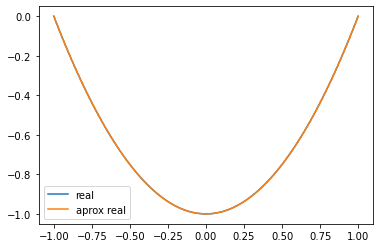

In [14]:
f= lambda x: -2
real = lambda x: x**2-1

N_vals=100 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,len(X))
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox real")
plt.legend()

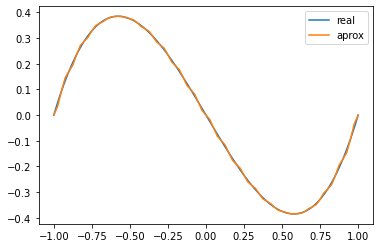

In [15]:
f= lambda x:-6*x
real= lambda x: x*(x+1)*(x-1) 

N_vals=20 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

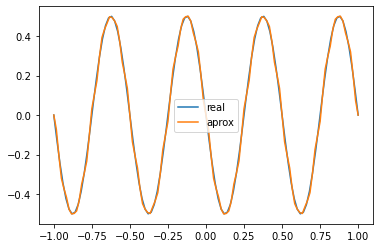

In [16]:
f= lambda x: -16*np.pi**2*np.cos(2*np.pi*x)*np.sin(2*np.pi*x)
real = lambda x: -np.sin(2*np.pi*x)*np.cos(2*np.pi*x)

N_vals=30 #Num intervalos
Nq=7 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

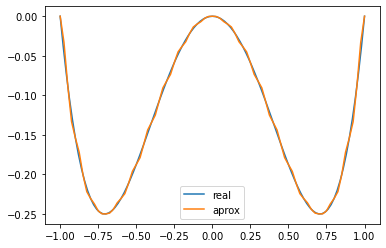

In [17]:
f=lambda x:2-12*x**2
real = lambda x:-x**2*(1 - x**2)

N_vals=20 #Num intervalos
Nq=20 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

Ejemplos cuyas condiciones de contorno no son 0

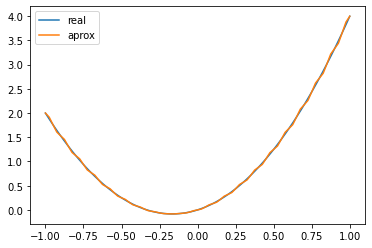

In [18]:
f= lambda x: -6
real = lambda x: 3*x**2+x

N_vals=20 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=2
cond2=4
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

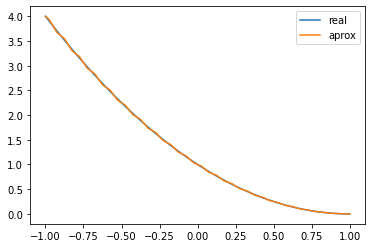

In [19]:
f= lambda x: -2
real = lambda x: (x-1)**2

N_vals=20 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=4
cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

# Dimensión 2

In [20]:
def Indices(k,m):
    '''
    A partir de un número k (nodo k) obtenemos los índices (i,j) para saber a qué posición nos referimos
    Con la variable m indicamos el número de filas y columnas de la matriz total(consideramos matrices cuadradas)
    '''
    i=k%(m+1)
    j=k//(m+1)
    return (i,j)

In [21]:
Indices(3,2)

(0, 1)

In [22]:
def M_Global_2D(m,p,Nq):
    
    D=M_Difusion_Global(m,p,Nq)
    M=M_Masa_Global(m,p,Nq)
    A=np.zeros(((m*p+1)*(m*p+1),(m*p+1)*(m*p+1)))
    
    for k1 in range(0,(m*p+1)*(m*p+1)):
        i1,j1=Indices(k1,m*p)
        #print(" ")
        #print("k1: ",k1, "i1,j1: ",i1,j1)
        for k2 in range(0,(m*p+1)*(m*p+1)):
            i2,j2=Indices(k2,m*p)
            #print("k2: ",k2, "i2,j2: ",i2,j2 )
            A[k1][k2]=D[i1][i2]*M[j1][j2]+M[i1][i2]*D[j1][j2]
                        
    return A

25


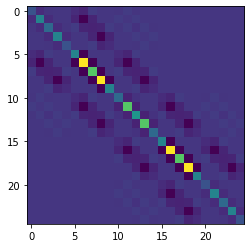

In [23]:
A=M_Global_2D(2,2,5)
print(len(A))
plt.imshow(A)

In [24]:
def V_Indep_Global_2D(m,p,Nq,f1,f2): 
    
    B=V_Indep_Global(m,p,Nq,f1)
    B1=V_Indep_Global(m,p,Nq,f2)
    B2=np.zeros((m*p+1)*(m*p+1))
    
    for k in range(0,(m*p+1)*(m*p+1)):
        i1,j1=Indices(k,m*p)
        #print("i1,j1",i1,j1)
        B2[k]=B[i1]*B1[j1]
                        
    return B2

# Probamos con grado 1

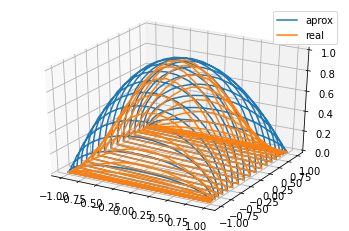

In [26]:
f1=lambda x: 1/2*(np.pi**2)*np.cos(np.pi/2*x)
f2= lambda y: np.cos(np.pi/2*y)
m=20
A=M_Global_2D(m,1,5)
#print(A)
B=V_Indep_Global_2D(m,1,5,f1,f2)
#print(B)

for i in range(0,round(math.sqrt(len(A)))): #bloquea los nodos de la frontera inferior y superior, imponiendo la diagonal de los respectivos nodos
    A[i][i]=10**30
    A[len(A)-1-i][len(A)-1-i]=10**30
    B[i]=0
    B[len(A)-1-i]=0
for i in range(0,(len(A))): 
    if(i%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
    if((i+1)%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
        
U=np.linalg.solve(A,B)

fig = plt.figure()
ax = plt.axes(projection='3d')

g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

i=[]
j=[]
real=[]

for k in range(0,len(U)):
    i.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m)[0]])
    j.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox")
#ax.scatter3D(i,j,U)
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

Parece que llegamos pero no es la misma

# Grado 2

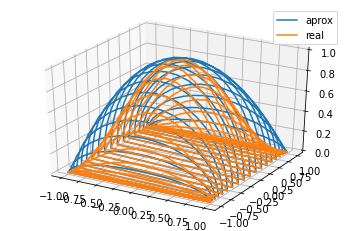

In [27]:
f1=lambda x: 1/2*(np.pi**2)*np.cos(np.pi/2*x)
f2= lambda y: np.cos(np.pi/2*y)
m=10
p=2
Nq=5
A=M_Global_2D(m,p,Nq)
#print(A)
B=V_Indep_Global_2D(m,p,Nq,f1,f2)
#print(B)

for i in range(0,round(math.sqrt(len(A)))): #bloquea los nodos de la frontera inferior y superior, imponiendo la diagonal de los respectivos nodos
    A[i][i]=10**30
    A[len(A)-1-i][len(A)-1-i]=10**30
    B[i]=0
    B[len(A)-1-i]=0
for i in range(0,(len(A))): 
    if(i%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
    if((i+1)%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
        
U=np.linalg.solve(A,B)

fig = plt.figure()
ax = plt.axes(projection='3d')

g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

i=[]
j=[]
real=[]

for k in range(0,len(U)):
    i.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[0]])
    j.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox") 
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

# Con grado 3

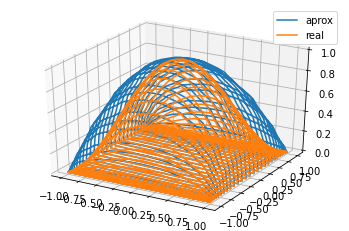

In [28]:
f1=lambda x: 1/2*(np.pi**2)*np.cos(np.pi/2*x)
f2= lambda y: np.cos(np.pi/2*y)
m=10
p=3
Nq=5
A=M_Global_2D(m,p,Nq)
#print(A)
B=V_Indep_Global_2D(m,p,Nq,f1,f2)
#print(B)

#Cuando funcione bien hago función para simplificar
for i in range(0,round(math.sqrt(len(A)))): #bloquea los nodos de la frontera inferior y superior, imponiendo la diagonal de los respectivos nodos
    A[i][i]=10**30
    A[len(A)-1-i][len(A)-1-i]=10**30
    B[i]=0
    B[len(A)-1-i]=0
for i in range(0,(len(A))): 
    if(i%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
    if((i+1)%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
        
U=np.linalg.solve(A,B)

fig = plt.figure()
ax = plt.axes(projection='3d')

g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

i=[]
j=[]
real=[]

for k in range(0,len(U)):
    i.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[0]])
    j.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox") 
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

# Con grado 4

C:\Users\isabe\Desktop\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
C:\Users\isabe\Desktop\WPy64-3760\python-3.7.6.amd64\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


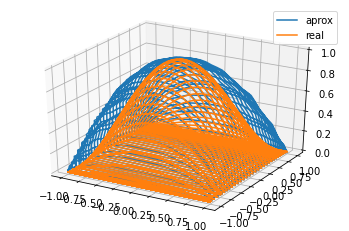

In [29]:
f1=lambda x: 1/2*(np.pi**2)*np.cos(np.pi/2*x)
f2= lambda y: np.cos(np.pi/2*y)
m=10
p=4
Nq=5
A=M_Global_2D(m,p,Nq)
#print(A)
B=V_Indep_Global_2D(m,p,Nq,f1,f2)
#print(B)

#Cuando funcione bien hago función para simplificar
for i in range(0,round(math.sqrt(len(A)))): #bloquea los nodos de la frontera inferior y superior, imponiendo la diagonal de los respectivos nodos
    A[i][i]=10**30
    A[len(A)-1-i][len(A)-1-i]=10**30
    B[i]=0
    B[len(A)-1-i]=0
for i in range(0,(len(A))): 
    if(i%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
    if((i+1)%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
        
U=np.linalg.solve(A,B)

fig = plt.figure()
ax = plt.axes(projection='3d')

g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

i=[]
j=[]
real=[]

for k in range(0,len(U)):
    i.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[0]])
    j.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox") 
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

Si tenemos 2 intervalos los nodos (-1,0,1)x(-1,0,1) y el único nodo que no es cero es el del centro, en este caso 4

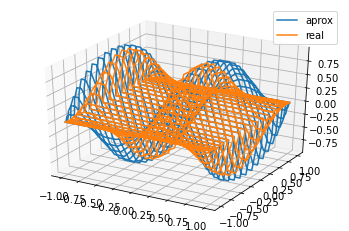

In [30]:
f1=lambda x: 17/4*(np.pi**2)*np.sin(2*np.pi*x)
f2= lambda y: np.cos(np.pi*y/2)
m=10
p=2
Nq=5
A=M_Global_2D(m,p,Nq)
#print(A)
B=V_Indep_Global_2D(m,p,Nq,f1,f2)
#print(B)

for i in range(0,round(math.sqrt(len(A)))): #bloquea los nodos de la frontera inferior y superior, imponiendo la diagonal de los respectivos nodos
    A[i][i]=10**30
    A[len(A)-1-i][len(A)-1-i]=10**30
    B[i]=0
    B[len(A)-1-i]=0
for i in range(0,(len(A))): 
    if(i%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
    if((i+1)%(round(math.sqrt(len(A))))==0): #bloquea la frontera izquierda
        A[i][i]=10**30
        B[i]=0
        
U=np.linalg.solve(A,B)

fig = plt.figure()
ax = plt.axes(projection='3d')

g = lambda x,y: np.sin(np.pi*2 *x)*np.cos(np.pi*y/2)

i=[]
j=[]
real=[]

for k in range(0,len(U)):
    i.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[0]])
    j.append(Lobato(math.sqrt(len(U))-1,-1,1).getNodes()[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox") 
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   